<a href="https://colab.research.google.com/github/rkrissada/100DayOfMLCode/blob/master/day_047_autoencode_noise_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
%matplotlib inline

from keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step


In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

## normalize and reshape
x_train = x_train/255.
x_val = x_val/255.

In this autoencoder network, we will add convolutional layers because convolutional networks works really well with the image inputs. To apply convolutions on image data, we will reshape our inputs in the form of 28 * 28 matrix

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

#### Noisy Images
We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example:

    - Salt and Pepper Noise
    - Gaussian Noise
    - Periodic Noise
    - Speckle Noise
Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.

In [0]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

x_train_n = seq_object.augment_images(x_train * 255) / 255
x_val_n = seq_object.augment_images(x_val * 255) / 255

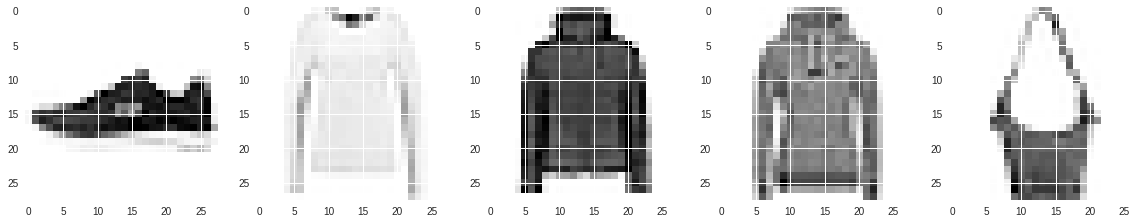

In [6]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 10)
for i in range(5,10):
    ax[i-5].imshow(x_train[i].reshape(28, 28))
plt.show()

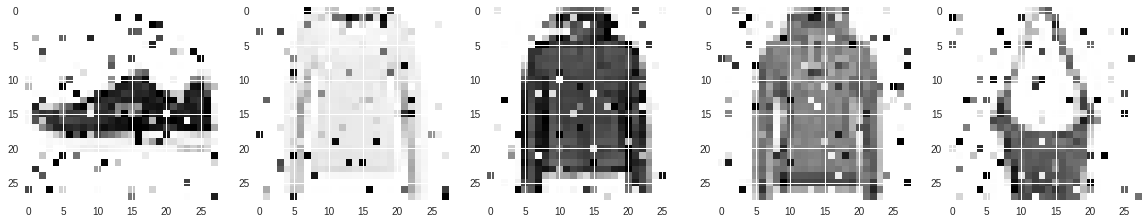

In [7]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 10)
for i in range(5,10):
    ax[i-5].imshow(x_train_n[i].reshape(28, 28))
plt.show()

Lets now create the model architecture for the autoencoder. Lets understand what type of network needs to be created for this problem.

**Encoding Architecture:**

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.

**Decoding Architecture:**

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well. Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.

In [8]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

Train the model with early stopping callback. Increase the number of epochs to a higher number for better results.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(x_train_n, x_train, epochs=10, batch_size=2048, validation_data=(x_val_n, x_val), callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 13s 299us/step - loss: 0.0951 - val_loss: 0.0608
Epoch 2/10
42000/42000 [==============================] - 6s 135us/step - loss: 0.0480 - val_loss: 0.0398
Epoch 3/10
42000/42000 [==============================] - 6s 135us/step - loss: 0.0361 - val_loss: 0.0332
Epoch 4/10
42000/42000 [==============================] - 6s 135us/step - loss: 0.0312 - val_loss: 0.0292
Epoch 5/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.0279 - val_loss: 0.0273
Epoch 6/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.0261 - val_loss: 0.0250
Epoch 7/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 8/10
42000/42000 [==============================] - 6s 136us/step - loss: 0.0234 - val_loss: 0.0231
Epoch 9/10
42000/42000 [=============================

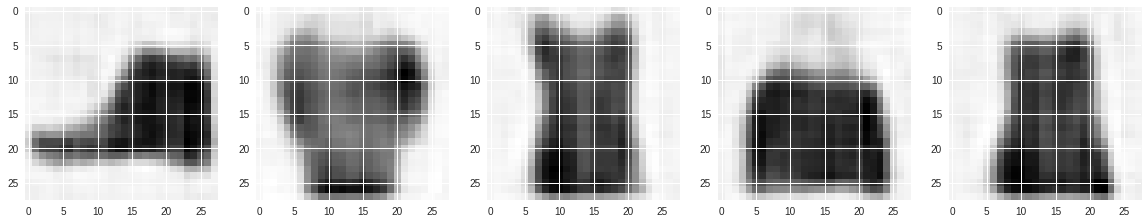

In [11]:
preds = model_2.predict(x_val_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 10)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()